In [353]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable,Function
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def show_grid(image,samples,num):
    image = np.asarray(image)
    sample_arr = list()
    image = np.asarray(image)
    for i in range(num):
        sample_img = crop_image(image,samples[i],107,0)
        sample_arr.append(sample_img)
    d = np.stack(sample_arr,axis=0)
    torch_img = torchvision.utils.make_grid(torch.from_numpy(np.transpose(d,(0,3,1,2))))
    npimg = torch_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats
def train(model, pdist, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    #batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        
        # forward
        pos_fc5 = model(batch_pos_feats, in_layer=in_layer,out_layer='fc5')
        neg_fc5 = model(batch_neg_feats, in_layer=in_layer,out_layer='fc5')
        
        # optimize
        p_dist = pdist(pos_fc5,pos_fc5)
        n_dist = pdist(pos_fc5,neg_fc5)
        #p_mask = torch.ge(p_dist,0.2)
        #p_loss = 3*torch.mean(torch.masked_select(p_dist,p_mask))
        p_loss = 3*torch.mean(p_dist)
        n_loss = 1-torch.mean(n_dist)
        loss = p_loss+torch.clamp(n_loss,min=0.0)
        print(loss)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()
    return p_dist,n_dist
        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data

class PairwiseDistance(nn.Module):
    def __init__(self):
        super(PairwiseDistance, self).__init__()
        

    def forward(self, x1, x2):
        x2 = torch.unsqueeze(x2,dim=1)
        diff = x2 - x1
        dist = torch.pow(diff,2).sum(dim=2)
        dist = dist/torch.max(dist,dim = 0)[0]
        #dist = torch.pow(dist,0.5)
        #distance = torch.mean(dist)
        return dist

In [354]:
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Matrix'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers
pdist = PairwiseDistance()

update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
neg_examples = np.random.permutation(neg_examples)
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats

In [355]:
init_optimizer = set_optimizer(model, opts['lr_init']*50)
p_dist,n_dist = train(model, pdist, init_optimizer,pos_feats, neg_feats, 100)


Variable containing:
 2.7068
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.6344
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.6781
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.6241
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.1564
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.1675
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.2295
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.9474
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.1312
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.0819
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.0367
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.6364
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 2.0562
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 1.6968
[torch.cuda.FloatTenso

In [44]:
dist = p_dist(pos_feats,neg_feats)
dist

TypeError: 'Variable' object is not callable

In [10]:
1-torch.mean(n_dist)

Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [6]:
torch.sum(p_dist>0.5)

Variable containing:
 81
[torch.cuda.ByteTensor of size 1 (GPU 0)]

In [32]:
torch.min(n_dist)

Variable containing:
1.00000e-02 *
  5.4912
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [9]:
n_dist

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 96x32 (GPU 0)]

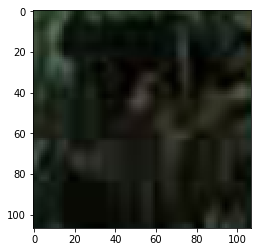

In [356]:
sample_generator = SampleGenerator('gaussian', image.size, 0.6, 1.05, valid=True)
pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)
i=0
t_bbox = target_bbox[np.newaxis,:]
init_image = Image.open(img_list[0]).convert('RGB')
target_feat_fc5 = forward_samples(model,init_image,t_bbox,out_layer='fc5')
show_grid(init_image,t_bbox,1)
# Init pos/neg features for update
pos_feats_all = [pos_feats[:opts['n_pos_update']]]
neg_feats_all = [neg_feats[:opts['n_neg_update']]]

0.9843301773071289

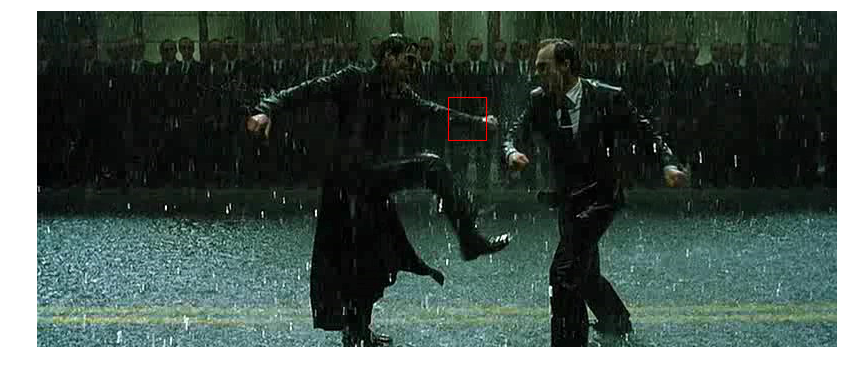

In [384]:
# iterating ........
i=i+1
image = Image.open(img_list[i]).convert('RGB')
# Estimate target bbox
samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
samples_feats_fc5 = forward_samples(model, image, samples,out_layer='fc5')

probFea = target_feat_fc5
galFea = samples_feats_fc5

diff = galFea-probFea
dist = torch.pow(diff,2).sum(dim=1)
original_dist = dist/torch.max(dist)
original_dist,initial_rank = torch.sort(original_dist)
#original_dist = original_dist.cpu().numpy()
#initial_rank = np.argsort(original_dist).astype(np.int32)

samples = samples[initial_rank,:]
target_bbox = samples[:5,:].mean(axis=0)

# Draw pos/neg samples
pos_examples = gen_samples(pos_generator, target_bbox, 
                            opts['n_pos_update'],
                            opts['overlap_pos_update'])
neg_examples = gen_samples(neg_generator, target_bbox, 
                            opts['n_neg_update'],
                            opts['overlap_neg_update'])

# Extract pos/neg features
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
pos_feats_all.append(pos_feats)
neg_feats_all.append(neg_feats)
if len(pos_feats_all) > opts['n_frames_long']:
    del pos_feats_all[0]
if len(neg_feats_all) > opts['n_frames_short']:
    del neg_feats_all[0]
    
show_result(image,target_bbox)
original_dist[initial_rank[:5]].mean()

In [35]:
original_dist


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.cuda.FloatTensor of size 256 (GPU 0)]